In [19]:
%%javascript
require.config({ 
    paths: { 
    d3: 'https://d3js.org/d3.v7.min'
}});

require(["d3"], function(d3) {
    window.d3 = d3;
});

<IPython.core.display.Javascript object>

In [20]:
import sparg
import tskit
import numpy as np
import matplotlib.pyplot as plt
import math
import tskit_arg_visualizer as viz

# dispersal_rates_hist

The following code takes a single SLiM simulation (slim_0.25rep4sigma.trees), subsets the ARG to 50 randomly chosen samples, and compares the dispersal rate estimates from that subset ARG. This is repeated 200 times and the distribution of disperal rate estimates is compared to the expected values for the simulation. If the output file does not exist, uncomment the code block below to regenerate it. Otherwise skip.

In [28]:
'''
outfile = open("QE/slim/slim_0.25rep4sigma_dispersalrateestimates_50_official.txt", "w")
for i in range(200):
    print(i)
    np.random.seed(i)
    keep_nodes = list(np.random.choice(ts.samples(), 50, replace=False))
    ts_sim = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True)
    ts_diff, maps_diff, critical_diff = sparg.remove_excess_nodes(ts=ts_sim)
    ts_cut = sparg.cut_ts_at_gmrca(ts=ts_diff)
    dispersal_rate, cov_mat, paths = sparg.estimate_spatial_parameters(ts=ts_cut)
    outfile.write(str(dispersal_rate[0][0]) + " " + str(dispersal_rate[1][1]) + "\n")
outfile.close()
''';

In [21]:
dispersal_rates = np.loadtxt("QE/slim/slim_0.25rep4sigma_dispersalrateestimates_50_official.txt")

In [24]:
print(np.median(dispersal_rates[:,0]), np.median(dispersal_rates[:,1]))

0.2551862878780835 0.3183066446929465


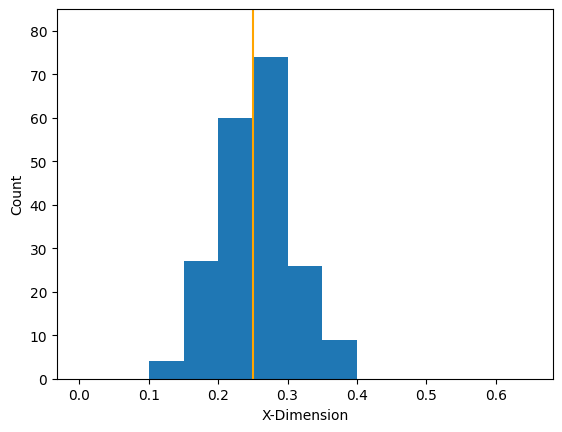

In [26]:
plt.hist(dispersal_rates[:,0], bins=[i/100 for i in range(0, 70, 5)])
plt.axvline(0.25, color="orange")
plt.xlabel("X-Dimension")
plt.ylabel("Count")
plt.ylim(0,85)
plt.xlim(0,0.7)
plt.show()

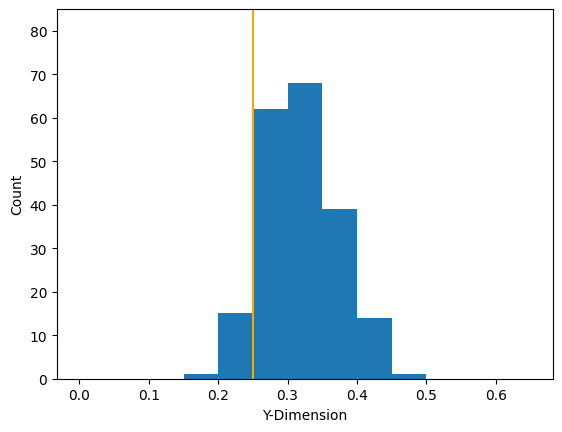

In [25]:
plt.hist(dispersal_rates[:,1], bins=[i/100 for i in range(0, 70, 5)])
plt.axvline(0.25, color="orange")
plt.xlabel("Y-Dimension")
plt.ylabel("Count")
plt.ylim(0,85)
plt.xlim(0,0.7)
plt.show()

# ancestral_locations_plots

In [6]:
ts = tskit.load("QE/slim/slim_0.25rep4sigma.trees")
np.random.seed(1)
keep_nodes = list(np.random.choice(ts.samples(), 50, replace=False))
ts_sim = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True)
ts_tracking, maps_tracking, critical_tracking =  sparg.remove_excess_nodes(ts=ts_sim, keep_young_nodes={"below":2000,"step":10})
ts_tracking_final = sparg.cut_ts_at_gmrca(ts=ts_tracking)

In [7]:
dispersal_rate, cov_mat, paths, locations_of_nodes, variances_in_node_locations = sparg.estimate_spatial_parameters(ts=ts_tracking_final, return_ancestral_node_positions=critical_tracking)

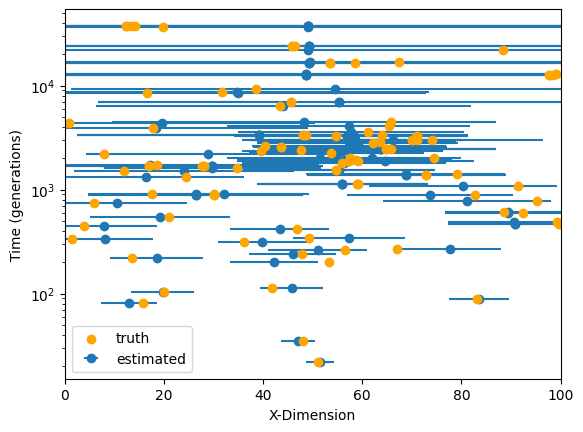

In [8]:
true_locs = []
estimated_locs = []
times = []
errors = []
ranks = []
unique_times = list(np.unique(ts_tracking_final.tables.nodes.time))
for node in locations_of_nodes:
    true_locs.append(ts_tracking_final.individual(ts_tracking_final.node(node).individual).location[0])
    estimated_locs.append(locations_of_nodes[node][0])
    times.append(ts_tracking_final.node(node).time)
    ranks.append(unique_times.index(ts_tracking_final.node(node).time))
    errors.append(2*math.sqrt(round(variances_in_node_locations[node][0][0])))
plt.errorbar(estimated_locs, times, xerr=errors, label="estimated", fmt="o", zorder=1)
plt.scatter(true_locs, times, color="orange", label="truth", zorder=2)
plt.legend(loc="lower left")
plt.yscale("log")
plt.xlim(0, 100)
plt.xlabel("X-Dimension")
plt.ylabel("Time (generations)")
plt.show()

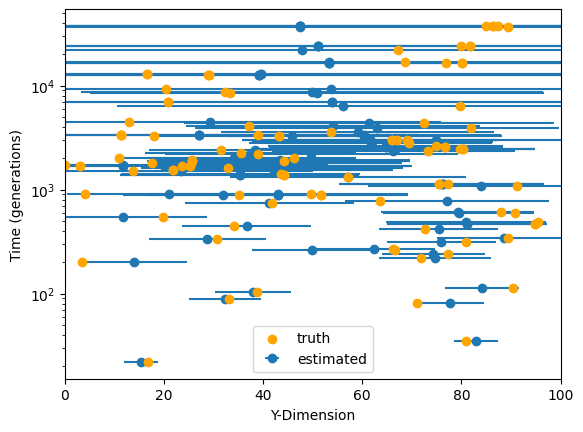

In [9]:
true_locs = []
estimated_locs = []
times = []
errors = []
ranks = []
unique_times = list(np.unique(ts_tracking_final.tables.nodes.time))
for node in locations_of_nodes:
    true_locs.append(ts_tracking_final.individual(ts_tracking_final.node(node).individual).location[1])
    estimated_locs.append(locations_of_nodes[node][1])
    times.append(ts_tracking_final.node(node).time)
    ranks.append(unique_times.index(ts_tracking_final.node(node).time))
    errors.append(2*math.sqrt(round(variances_in_node_locations[node][1][1])))
plt.errorbar(estimated_locs, times, xerr=errors, label="estimated", fmt="o", zorder=1)
plt.scatter(true_locs, times, color="orange", label="truth", zorder=2)
plt.legend(loc="lower center")
plt.yscale("log")
plt.xlim(0, 100)
plt.xlabel("Y-Dimension")
plt.ylabel("Time (generations)")
plt.show()

# tracking_recomb_sample

Here, we track the lineages associated with sample 5 in the ARG. This sample is beneath a recombination node, so has multiple lineages. We can show how our ancestral location estimates for these lineages split apart at the recombination event.

In [10]:
unique_paths = sparg.identify_unique_paths(ts=ts_tracking_final)
from_five_nodes = []
from_five_paths = []
for path in unique_paths:
    if path[0] == 5:
        from_five_paths.append(path)
        for node in path:
            if node not in from_five_nodes:
                from_five_nodes.append(node)
dispersal_rate_tracking, cov_mat_tracking, paths_tracking, locations_of_nodes_tracking, variances_in_node_locations_tracking = sparg.estimate_spatial_parameters(ts=ts_tracking_final, return_ancestral_node_positions=from_five_nodes)

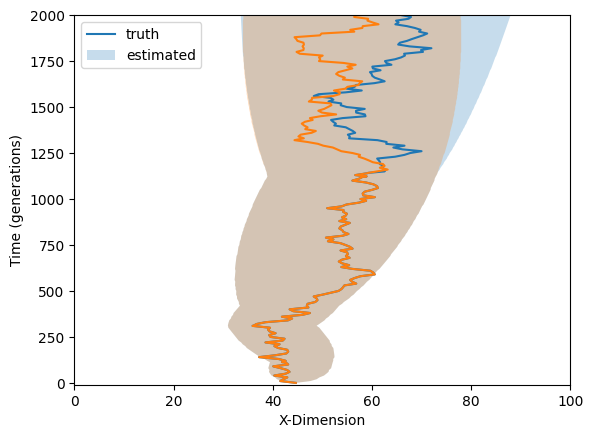

In [13]:
for i,path in enumerate(from_five_paths[4:6]):
    locations = []
    times = []
    for node in path:
        locations.append(ts_tracking_final.individual(ts_tracking_final.node(node).individual).location[0])
        times.append(ts_tracking_final.node(node).time)
    if i == 0:
        plt.plot(locations, times, label="truth")
    else:
        plt.plot(locations, times)

unique_times = list(np.unique(ts_tracking_final.tables.nodes.time))
for i,p in enumerate(from_five_paths[4:6]):
    p_time = []
    p_rank = []
    p_locs = []
    p_error = []
    p_left = []
    p_right = []
    for n in p:
        p_time.append(ts_tracking_final.node(n).time)
        p_rank.append(unique_times.index(ts_tracking_final.node(n).time))
        p_locs.append(locations_of_nodes_tracking[n][0])
        p_error.append(2*math.sqrt(round(variances_in_node_locations_tracking[n][0][0])))    # Error is two standard deviations (95% confidence interval)
        p_left.append(locations_of_nodes_tracking[n][0]-(2*math.sqrt(round(variances_in_node_locations_tracking[n][0][0]))))
        p_right.append(locations_of_nodes_tracking[n][0]+(2*math.sqrt(round(variances_in_node_locations_tracking[n][0][0]))))
    if i == 0:
        plt.fill_betweenx(y=np.array(p_time, dtype="float"), x1=np.array(p_left, dtype="float"), x2=np.array(p_right, dtype="float"), alpha=0.25, label="estimated")
    else:
        plt.fill_betweenx(y=np.array(p_time, dtype="float"), x1=np.array(p_left, dtype="float"), x2=np.array(p_right, dtype="float"), alpha=0.25)

plt.ylim(-10, 2000)
plt.xlim(0, 100)
plt.legend(loc="upper left")
plt.xlabel("X-Dimension")
plt.ylabel("Time (generations)")
plt.show()

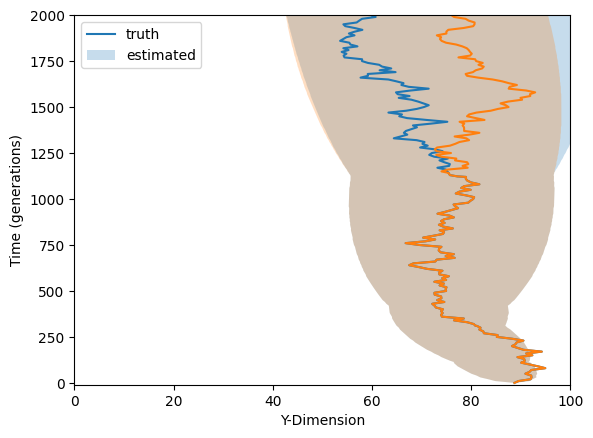

In [15]:
for i,path in enumerate(from_five_paths[4:6]):
    locations = []
    times = []
    for node in path:
        locations.append(ts_tracking_final.individual(ts_tracking_final.node(node).individual).location[1])
        times.append(ts_tracking_final.node(node).time)
    if i == 0:
        plt.plot(locations, times, label="truth")
    else:
        plt.plot(locations, times)

unique_times = list(np.unique(ts_tracking_final.tables.nodes.time))
for i,p in enumerate(from_five_paths[4:6]):
    p_time = []
    p_rank = []
    p_locs = []
    p_error = []
    p_left = []
    p_right = []
    for n in p:
        p_time.append(ts_tracking_final.node(n).time)
        p_rank.append(unique_times.index(ts_tracking_final.node(n).time))
        p_locs.append(locations_of_nodes_tracking[n][1])
        p_error.append(2*math.sqrt(round(variances_in_node_locations_tracking[n][1][1])))    # Error is two standard deviations (95% confidence interval)
        p_left.append(locations_of_nodes_tracking[n][1]-(2*math.sqrt(round(variances_in_node_locations_tracking[n][1][1]))))
        p_right.append(locations_of_nodes_tracking[n][1]+(2*math.sqrt(round(variances_in_node_locations_tracking[n][1][1]))))
    if i == 0:
        plt.fill_betweenx(y=np.array(p_time, dtype="float"), x1=np.array(p_left, dtype="float"), x2=np.array(p_right, dtype="float"), alpha=0.25, label="estimated")
    else:
        plt.fill_betweenx(y=np.array(p_time, dtype="float"), x1=np.array(p_left, dtype="float"), x2=np.array(p_right, dtype="float"), alpha=0.25)

plt.ylim(-10, 2000)
plt.xlim(0, 100)
plt.legend(loc="upper left")
plt.xlabel("Y-Dimension")
plt.ylabel("Time (generations)")
plt.show()